# Assignment 2.2: Convolutional Neural Network
Student Name 1: Mateusz Klimas

Student Name 2: Juan Luis Ruiz-Tagle

Student Name 3: Jorge Martín Lasaosa

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

# CIFAR 100 Dataset

In [1]:
from keras.datasets import cifar100
(_x_train, _y_train), (_x_test, _y_test) = cifar100.load_data(label_mode='fine')

Using TensorFlow backend.


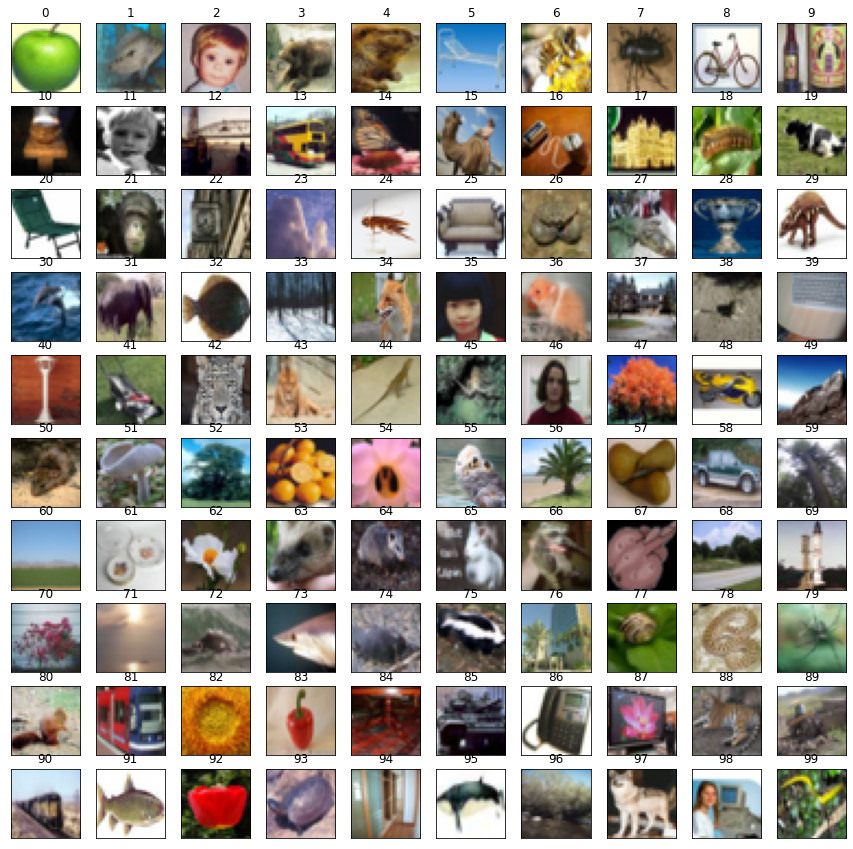

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(_y_train)
num_classes = len(class_names)

fig, axes = plt.subplots(10, 10,figsize=(15,15))
for i in range(num_classes):
    ax = axes.flatten()[i]
    indices = np.where(np.isin(_y_train, class_names[i]))[0]
    ax.imshow(_x_train[int(np.random.choice(indices, 1))])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(i)
plt.show()

In [3]:
# Data pre-processing
x_val = _x_train[40000:]
y_val = _y_train[40000:]
x_train = _x_train[:40000]
y_train = _y_train[:40000]
x_test = _x_test
y_test = _y_test

# Normalize the images to be values in range [0, 1]
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_val /= 255.0
x_test /= 255.0

from keras.utils import np_utils
# Converts a class vector (integers) to binary class matrix
tr_labels = np_utils.to_categorical(y_train, num_classes)
va_labels = np_utils.to_categorical(y_val, num_classes)
te_labels = np_utils.to_categorical(y_test, num_classes)

CIFAR_SIZE = (32, 32)

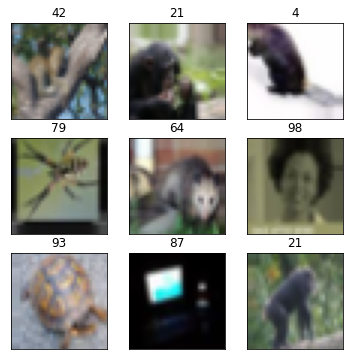

In [9]:
import cv2

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.1, fill_mode='nearest')
datagen.fit(x_train, augment=True)

for x_batch, y_batch in datagen.flow(x_train, tr_labels, batch_size=9):
    # create a grid of 3x3 images
    fig = plt.figure(figsize=(6,6))
    for i in range(0, 9):
        ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
        ax.set_title(np.argmax(y_batch[i]))
        plt.imshow(x_batch[i])
    # show the plot
    plt.show()
    break

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras import optimizers
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.initializers import RandomNormal
from keras.optimizers import Adam
import keras

act='relu'
s=2

input_shape = (CIFAR_SIZE[0], CIFAR_SIZE[1], 3)

cnn = Sequential()

cnn.add(Conv2D(64, (3,3), padding='same', kernel_initializer='random_normal', input_shape=x_train.shape[1:]))
cnn.add(BatchNormalization())
cnn.add(Activation(act))
cnn.add(Dropout(0.2))

cnn.add(Conv2D(128, (3,3), padding='same', kernel_initializer='random_normal'))
cnn.add(BatchNormalization())
cnn.add(Activation(act))
cnn.add(Dropout(0.2))

cnn.add(Conv2D(128, (3,3), padding='same', kernel_initializer=RandomNormal(stddev=0.01)))
cnn.add(BatchNormalization())
cnn.add(Activation(act))
cnn.add(Dropout(0.2))

cnn.add(MaxPooling2D(pool_size=(2,2), strides=s))
cnn.add(Dropout(0.2))

cnn.add(Conv2D(128, (3,3), padding='same', kernel_initializer=RandomNormal(stddev=0.01)))
cnn.add(BatchNormalization())
cnn.add(Activation(act))
cnn.add(Dropout(0.2))

cnn.add(Conv2D(128, (3,3), padding='same', kernel_initializer='random_normal'))
cnn.add(BatchNormalization())
cnn.add(Activation(act))
cnn.add(Dropout(0.2))


cnn.add(Conv2D(256, (3,3), padding='same', kernel_initializer='random_normal'))

cnn.add(MaxPooling2D(pool_size=(2,2), strides=s))
cnn.add(BatchNormalization())
cnn.add(Activation(act))
cnn.add(Dropout(0.2))

cnn.add(Conv2D(256, (3,3), padding='same', kernel_initializer='random_normal'))
cnn.add(BatchNormalization())
cnn.add(Activation(act))
cnn.add(Dropout(0.2))

cnn.add(Conv2D(256, (3,3), padding='same', kernel_initializer='random_normal'))
cnn.add(BatchNormalization())
cnn.add(Activation(act))
cnn.add(Dropout(0.2))

cnn.add(MaxPooling2D(pool_size=(2,2), strides=s))

cnn.add(Conv2D(512, (3,3), padding='same', kernel_initializer='random_normal'))
cnn.add(BatchNormalization())
cnn.add(Activation(act))
cnn.add(Dropout(0.2))

cnn.add(MaxPooling2D(pool_size=(2,2), strides=s))
cnn.add(Dropout(0.2))

cnn.add(Flatten())
cnn.add(Dense(num_classes, activation='softmax'))

cnn.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 128)       0         
__________

In [10]:
from time import time

train_steps = int(len(x_train) / 16)
valid_steps = int(len(x_val) / 16)
data = cnn.fit_generator(datagen.flow(x_train, tr_labels, batch_size=16), 
                         epochs=50, 
                         steps_per_epoch=train_steps, 
                         verbose=1, 
                         validation_data=(x_val, va_labels), 
                         validation_steps=valid_steps)

start = time()
loss, acc = cnn.evaluate(x_test, te_labels, verbose=2)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Epoch 1/50
2500/2500 [==============================] - 185s 74ms/step - loss: 5.5592 - acc: 0.0204 - val_loss: 4.3283 - val_acc: 0.0509
Epoch 2/50
2500/2500 [==============================] - 170s 68ms/step - loss: 3.9899 - acc: 0.0856 - val_loss: 3.9605 - val_acc: 0.1016
Epoch 3/50
2500/2500 [==============================] - 171s 68ms/step - loss: 3.5789 - acc: 0.1537 - val_loss: 3.5312 - val_acc: 0.1630
Epoch 4/50
2500/2500 [==============================] - 171s 68ms/step - loss: 3.2484 - acc: 0.2125 - val_loss: 3.2387 - val_acc: 0.2402
Epoch 5/50
2500/2500 [==============================] - 171s 69ms/step - loss: 2.9686 - acc: 0.2660 - val_loss: 2.8873 - val_acc: 0.3007
Epoch 6/50
2500/2500 [==============================] - 172s 69ms/step - loss: 2.7446 - acc: 0.3094 - val_loss: 2.6956 - val_acc: 0.3396
Epoch 7/50
2500/2500 [==============================] - 171s 68ms/step - loss: 2.5387 - acc: 0.3483 - val_loss: 2.6042 - val_acc: 0.3545
Epoch 8/50
2500/2500 [===================